# BIONIC Methods Tests and Data Visualization

## Exploration and Gene Filtering

In [1]:
# imports
from itertools import combinations
import numpy as np
import pandas as pd
import csv
# import pearsonr as pearsonr
# from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import argparse
import networkx as nx

In [3]:
#File Read
# df = pd.read_csv("../outputs/previous_attemps/locus_tag_processed.csv", sep=',', index_col=0, header=0)
# df

In [207]:
# df.index.isna().sum()

0

### Pre-processes the probe names
Pre-processed the gene expression data, separating the probe names and removing the probes from organs (ATC and ATM).

In [208]:
# with open('../outputs/previous_attemps/locus_tag_processed.csv', 'r') as file:
#     reader = csv.reader(file)
#     header = next(reader)
#     new_rows = []
#
#     for row in reader:
#         probe_names = [row[0][i:i+9] for i in range(0, len(row[0]), 9)]
#
#         # Filter out probes from organs (ATC and ATM)
#         probe_names = [probe for probe in probe_names if not probe.startswith('ATC') and not probe.startswith('ATM')]
#
#         # Remove ATM and ATC from the list of probe names if they are aliases
#         for i in range(len(probe_names)):
#             if probe_names[i] == 'ATC' or probe_names[i] == 'ATM':
#                 probe_names.pop(i)
#
#         if len(probe_names) > 0:
#             new_row = [';'.join(probe_names)] + row[1:]
#             new_rows.append(new_row)
#
# with open('../outputs/probes_alias_sep.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(header)
#     writer.writerows(new_rows)

In [214]:
#File Read
# df = pd.read_csv("../outputs/current_df/probes_alias_sep.csv", sep=',', index_col=0, header=0)
# df.index.isna().sum()

0

###  Map probe names to gene symbols
Map the probe names to gene symbols.

In [211]:
# def map_probes_to_genes(input_file, mapping_file):
#     # Read the mapping file and create a dictionary mapping probe names to gene symbols
#     probe_to_gene = {}
#     with open(mapping_file, 'r') as map_file:
#         for line in map_file:
#             probe, gene = line.strip().split()
#             probe_to_gene[probe] = gene
#
#     # Read in the input file as a DataFrame
#     input_df = pd.read_csv(input_file)
#
#     # Map the gene symbols for each probe name
#     gene_symbols = []
#     for probe_name in input_df['probe_name']:
#         sub_probes = probe_name.split(';')
#         gene_symbol = ''
#         if len(sub_probes) > 1:
#             gene_symbol += ';'.join([probe_to_gene.get(sub_probe, sub_probe) for sub_probe in sub_probes])
#         else:
#             gene_symbol += probe_to_gene.get(sub_probes[0], sub_probes[0])
#         gene_symbols.append(gene_symbol)
#
#     # Replace the "probe_name" column with "gene_symbol"
#     input_df['gene_symbol'] = gene_symbols
#     input_df = input_df.drop(columns=['probe_name'])
#     input_df = input_df.set_index('gene_symbol')
#
#     # Write the output file
#     input_df.to_csv('../outputs/current_df/genesymb_processed.csv')
#
# map_probes_to_genes('../outputs/probes_alias_sep.csv', '../gene_mapping/gene_symbol_mapping.txt')

In [213]:
#File Read
# df = pd.read_csv("../outputs/current_df/genesymb_processed.csv", sep=',', index_col=0, header=0)
# df.index.isna().sum()

0

## Scaling and Filtering

In [215]:
#File Read
df = pd.read_csv("../outputs/current_df/genesymb_processed.csv", sep=',', index_col=0, header=0)
df

,35D-0H-16C-A,35D-0H-16C-B,35D-2H-16C-A,37D-2H-16C-B,40D-5H-16C-A,40D-5H-16C-B,44D-9H-16C-A,44D-9H-16C-B,37D-2H-25C-A,37D-2H-25C-B,40D-5H-25C-A,40D-5H-25C-B,44D-9H-25C-A,44D-9H-25C-B
gene_symbol,,,,,,,,,,,,,,
AT2G42240,110.0,95.2,91.1,133.4,97.2,121.3,85.2,125.7,92.9,127.4,92.7,102.4,102.5,112.5
AT2G42250,28.5,27.2,34.2,29.3,28.4,30.5,18.5,24.6,26.7,12.0,42.5,35.3,21.9,31.7
AT2G42270,87.8,89.8,72.2,83.4,86.0,85.2,108.0,66.4,91.0,94.6,98.6,76.5,81.6,86.3
AT2G42280,42.5,35.0,21.2,30.5,17.1,14.4,19.8,1.2,41.7,31.1,21.2,17.3,18.2,12.3
AT2G42120,262.4,282.2,248.7,266.0,209.7,235.3,204.1,289.5,228.7,213.9,248.7,275.3,233.3,246.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257585_at,4.0,6.4,5.8,9.2,1.8,1.9,17.7,2.8,8.3,2.0,4.0,10.6,5.5,1.8
NLP1,3.9,8.8,13.0,6.1,13.8,31.0,12.8,0.5,9.4,22.8,14.7,5.5,27.7,1.5
TPS10,153.5,148.0,78.4,112.0,97.2,114.7,109.8,112.8,93.4,105.7,101.7,91.2,89.2,81.6


In [216]:
# Check the value ranges of the expression values for each conditions
grouped_data = df.groupby(df.columns, axis=1)
grouped_data.describe()

,,count,mean,std,min,25%,50%,75%,max
35D-0H-16C-A,35D-0H-16C-A,22429.0,272.141892,689.540573,0.0,17.8,78.0,248.8,11717.7
35D-0H-16C-B,35D-0H-16C-B,22429.0,262.220523,621.614470,0.0,15.7,80.8,253.6,9982.1
35D-2H-16C-A,35D-2H-16C-A,22429.0,270.547340,673.979040,0.0,20.1,82.6,251.1,11184.2
37D-2H-16C-B,37D-2H-16C-B,22429.0,264.255401,638.450487,0.0,16.1,82.4,250.6,9832.8
37D-2H-25C-A,37D-2H-25C-A,22429.0,266.858001,650.341099,0.0,20.2,87.2,254.1,11547.8
37D-2H-25C-B,37D-2H-25C-B,22429.0,265.292064,649.280440,0.1,16.6,85.7,254.0,10688.8
40D-5H-16C-A,40D-5H-16C-A,22429.0,267.300526,649.978332,0.0,15.9,80.7,254.4,10244.4
40D-5H-16C-B,40D-5H-16C-B,22429.0,266.866040,659.104229,0.0,19.7,83.9,248.7,10996.7
40D-5H-25C-A,40D-5H-25C-A,22429.0,266.394289,644.875845,0.1,20.5,87.4,256.6,11045.5
40D-5H-25C-B,40D-5H-25C-B,22429.0,266.249770,660.387459,0.2,18.2,84.8,253.6,11509.6


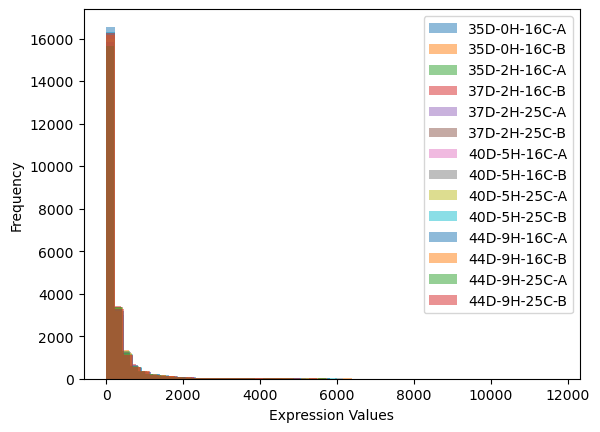

In [217]:
# Plot distribution of expression values for each condition

for sample, group in grouped_data:
    plt.hist(group[sample], bins=50, alpha=0.5, label=sample)

plt.xlabel("Expression Values")
plt.ylabel("Frequency")
plt.legend()

plt.show()

### Separate datasets by conditions

In [218]:
# Separate dataset by temperatures
sixteen_df = df.iloc[:, :8]
sixteen_df.to_csv("../outputs/sixteen_df.csv")
twenty_five_df = df.iloc[:, 8:16]
twenty_five_df.to_csv("../outputs/twenty_five_df.csv")

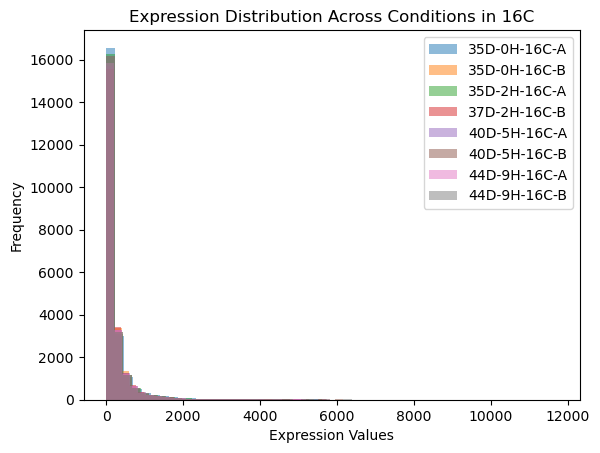

In [221]:
# Expression distribution across conditions in 16C
grouped_sixteen = sixteen_df.groupby(sixteen_df.columns, axis=1)

for sample, condition in grouped_sixteen:
    plt.hist(condition[sample], bins=50, alpha=0.5, label=sample)

plt.xlabel("Expression Values")
plt.ylabel("Frequency")
plt.title("Expression Distribution Across Conditions in 16C")
plt.legend()

plt.show()

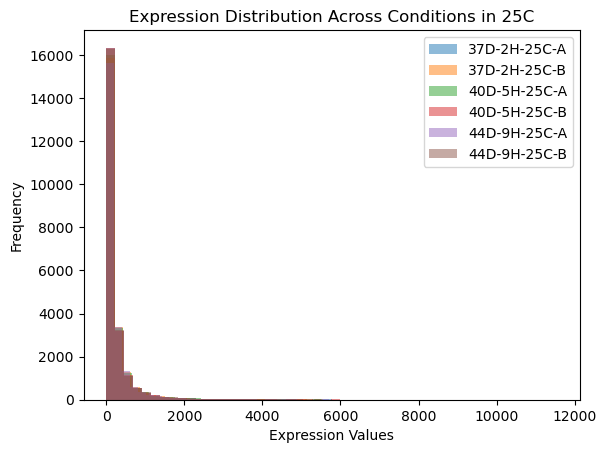

In [222]:
# Expression distribution across conditions in 25C
grouped_twenty_five = twenty_five_df.groupby(twenty_five_df.columns, axis=1)

for sample, condition in grouped_twenty_five:
    plt.hist(condition[sample], bins=50, alpha=0.5, label=sample)

plt.xlabel("Expression Values")
plt.ylabel("Frequency")
plt.title("Expression Distribution Across Conditions in 25C")
plt.legend()

plt.show()

### Filter by Coefficient of Variation

In [2]:
# Read condition files
sixteen_df = pd.read_csv("../outputs/separate_conditions/sixteen_df.csv", index_col='gene_symbol')
twenty_five_df = pd.read_csv("../outputs/separate_conditions/twenty_five_df.csv", index_col='gene_symbol')

In [3]:
# Calculate CoV for 16C

# Calculate the mean and standard deviation for each gene
sixteen_mean = sixteen_df.mean(axis=1)
sixteen_std = sixteen_df.std(axis=1)

# Calculate the coefficient of variation for each gene
sixteen_cv = (sixteen_std / sixteen_mean) * 100

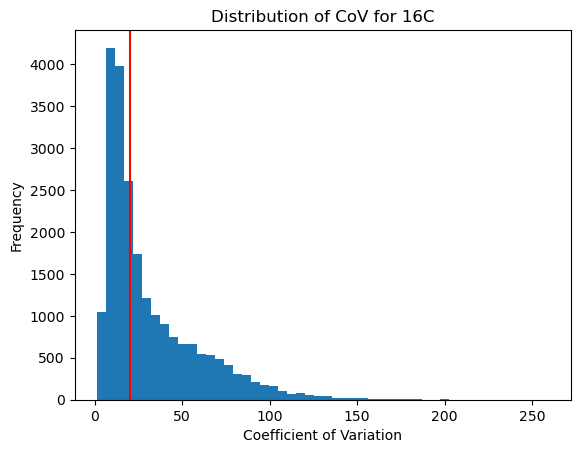

In [6]:
# Visualize CoV
plt.hist(sixteen_cv, bins=50)
plt.xlabel("Coefficient of Variation")
plt.ylabel("Frequency")
plt.title("Distribution of CoV for 16C")
plt.axline((20, 0), (20, 100), color='r')
plt.show()

In [7]:
# Filter out genes with a CV below 25%
threshold = 20
filtered_sixteen_genes = sixteen_cv[sixteen_cv >= threshold].index.tolist()
filtered_sixteen_df = sixteen_df.loc[filtered_sixteen_genes, :]
print(len(filtered_sixteen_genes))

11578


In [8]:
# Calculate CoV for 25C

# Calculate the mean and standard deviation for each gene
twenty_five_mean = twenty_five_df.mean(axis=1)
twenty_five_std = twenty_five_df.std(axis=1)

# Calculate the coefficient of variation for each gene
twenty_five_cv = (twenty_five_std / twenty_five_mean) * 100

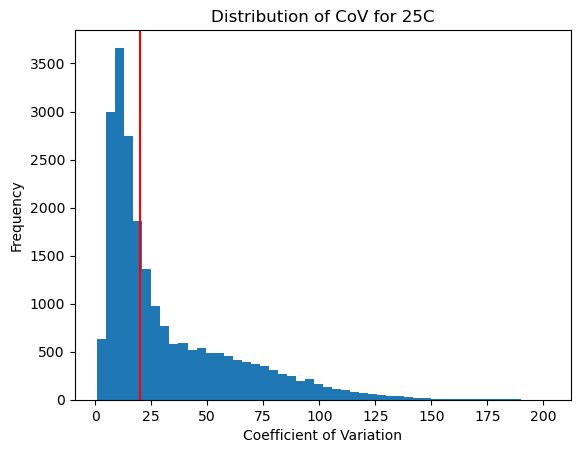

In [9]:
# Visualize CoV
plt.hist(twenty_five_cv, bins=50)
plt.xlabel("Coefficient of Variation")
plt.ylabel("Frequency")
plt.title("Distribution of CoV for 25C")
plt.axline((20, 0), (20, 100), color='r')
plt.show()

In [10]:
# Filter out genes with a CV below 25%
threshold = 20
filtered_cov_twentyfive_genes = twenty_five_cv[twenty_five_cv >= threshold].index.tolist()
filtered_twentyfive_cov_df = twenty_five_df.loc[filtered_cov_twentyfive_genes, :]
print(len(filtered_cov_twentyfive_genes))

10999


### Filter by Mean Absolute Deviation

In [3]:
# Calculate MAD for each gene in 16C

sixteen_mad = np.mean(np.abs(sixteen_df - sixteen_df.mean()), axis=1)
sixteen_median_mad = np.median(sixteen_mad)

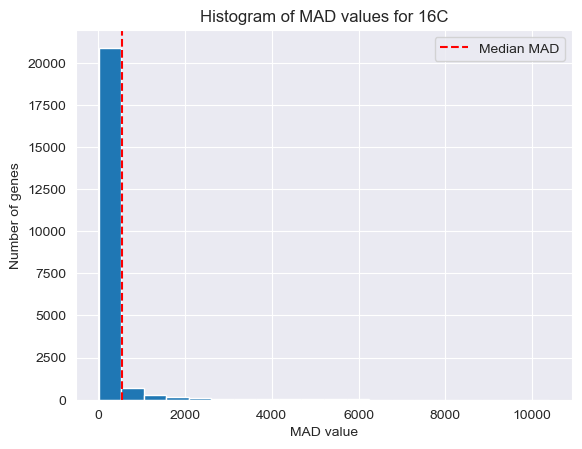

In [4]:
# Visualize MAD values
median_threshold = sixteen_median_mad * 2.4
plt.hist(sixteen_mad, bins=20)
plt.axvline(x=median_threshold, color='red', linestyle='--', label='Median MAD', )
plt.xlabel('MAD value')
plt.ylabel('Number of genes')
plt.title('Histogram of MAD values for 16C')
plt.legend()
plt.show()

In [5]:
# Filter out by the median of the MAD value
median_threshold = sixteen_median_mad * 2.4
filtered_sixteen_mad = sixteen_df.loc[sixteen_mad >= median_threshold, :]
print(len(filtered_sixteen_mad))

1484


In [6]:
# Calculate MAD for each gene in 25C

twenty_five_mad = np.mean(np.abs(twenty_five_df - twenty_five_df.mean()), axis=1)
twenty_five_median_mad = np.median(twenty_five_mad)

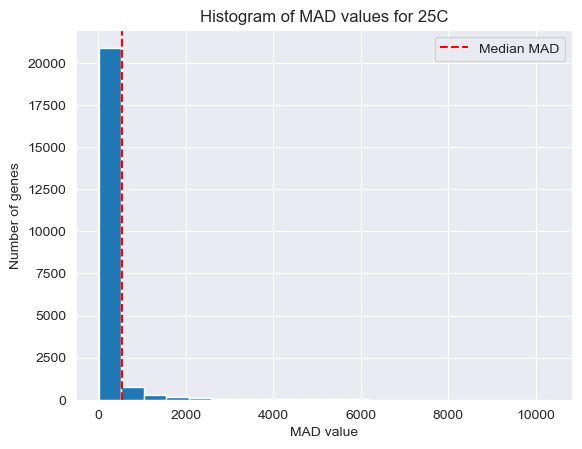

In [7]:
# Visualize MAD values for 25C
median_threshold = twenty_five_median_mad * 2.4
plt.hist(twenty_five_mad, bins=20)
plt.axvline(x=median_threshold, color='red', linestyle='--', label='Median MAD', )
plt.xlabel('MAD value')
plt.ylabel('Number of genes')
plt.title('Histogram of MAD values for 25C')
plt.legend()
plt.show()

In [8]:
# Filter out by the median of the MAD value
filtered_twenty_five_mad = twenty_five_df.loc[twenty_five_mad >= median_threshold, :]
print(len(filtered_twenty_five_mad))

1483


In [9]:
# Check if filtered genes from both conditions match
filtered_sixteen_mad_genes = filtered_sixteen_mad.index.tolist()
filtered_twenty_five_mad_genes = filtered_twenty_five_mad.index.tolist()
print(len(filtered_sixteen_mad_genes))
print(len(filtered_twenty_five_mad_genes))
print(len(set(filtered_sixteen_mad_genes).intersection(filtered_twenty_five_mad_genes)))

1484
1483
1310


In [11]:
filtered_sixteen_mad

,35D-0H-16C-A,35D-0H-16C-B,35D-2H-16C-A,37D-2H-16C-B,40D-5H-16C-A,40D-5H-16C-B,44D-9H-16C-A,44D-9H-16C-B
gene_symbol,,,,,,,,
AT2G42210,2761.9,2341.3,2618.3,2130.1,2568.0,2538.6,2688.9,2334.4
AT2G33040,2309.2,2130.5,2265.3,2421.0,2319.2,2820.0,2325.9,2745.9
AT2G45710,865.0,837.8,912.7,783.4,879.8,830.5,874.9,723.4
AT2G45640,790.2,1025.8,826.4,1055.3,827.0,1109.7,834.0,984.3
AT2G30570,2030.1,2394.5,2169.3,2546.0,2152.6,2969.9,2614.9,2281.0
...,...,...,...,...,...,...,...,...
UGD3,6975.1,6578.2,8496.7,8392.2,7349.3,7650.3,7263.2,7827.0
AT2G26500,1834.2,1488.0,1926.9,1753.8,2185.7,2243.5,2168.5,2198.2
AT2G26510,911.7,850.5,859.9,773.5,972.9,668.1,906.5,796.8


In [10]:
filtered_twenty_five_mad

,37D-2H-25C-A,37D-2H-25C-B,40D-5H-25C-A,40D-5H-25C-B,44D-9H-25C-A,44D-9H-25C-B
gene_symbol,,,,,,
AT2G42210,2913.2,2294.4,2580.2,2314.7,2559.5,2477.0
AT2G33040,2106.4,2437.6,2116.1,2451.6,1974.5,2292.9
AT2G39700,821.4,834.3,1207.4,907.2,902.7,1023.0
AT2G32180;AT2G32650,923.6,811.2,677.9,877.0,926.7,844.5
AT2G45710,875.2,697.2,796.1,769.4,905.9,845.5
...,...,...,...,...,...,...
AT2G26500,2736.0,2614.8,2347.7,2196.2,2346.9,2673.3
AT2G26510,958.8,894.1,1054.4,989.7,973.5,956.5
GLR2.6,1813.6,1284.2,1707.6,1344.3,1680.5,1393.2


## Scale filtered datasets

In [240]:
# Scale values by individual samples
scaler_sixteen_cov = StandardScaler()
scaled_sixteen_cov = scaler_sixteen_cov.fit_transform(filtered_sixteen_df)
scaled_sixteen_cov = pd.DataFrame(scaled_sixteen_cov, columns=filtered_sixteen_df.columns, index=filtered_sixteen_df.index)
scaled_sixteen_cov.to_csv("../outputs/separate_conditions/scaled_sixteen_cov.csv")

In [241]:
scaler_twentyfive_cov = StandardScaler()
scaled_twenty_five_cov = scaler_twentyfive_cov.fit_transform(filtered_twentyfive_cov_df)
scaled_twenty_five_cov = pd.DataFrame(scaled_twenty_five_cov, columns=filtered_twentyfive_cov_df.columns, index=filtered_twentyfive_cov_df.index)
scaled_twenty_five_cov.to_csv("../outputs/separate_conditions/scaled_twenty_five_cov.csv")

In [12]:
scaler_sixteen_mad = StandardScaler()
scaled_sixteen_mad = scaler_sixteen_mad.fit_transform(filtered_sixteen_mad)
scaled_sixteen_mad = pd.DataFrame(scaled_sixteen_mad, columns=filtered_sixteen_mad.columns, index=filtered_sixteen_mad.index)
scaled_sixteen_mad.to_csv("../outputs/separate_conditions/scaled_sixteen_mad.csv")

In [13]:
scaler_twentyfive_mad = StandardScaler()
scaled_twenty_five_mad = scaler_twentyfive_mad.fit_transform(filtered_twenty_five_mad)
scaled_twenty_five_mad = pd.DataFrame(scaled_twenty_five_mad, columns=filtered_twenty_five_mad.columns, index=filtered_twenty_five_mad.index)
scaled_twenty_five_mad.to_csv("../outputs/separate_conditions/scaled_twenty_five_mad.csv")

In [14]:
scaled_sixteen_mad

,35D-0H-16C-A,35D-0H-16C-B,35D-2H-16C-A,37D-2H-16C-B,40D-5H-16C-A,40D-5H-16C-B,44D-9H-16C-A,44D-9H-16C-B
gene_symbol,,,,,,,,
AT2G42210,0.356144,0.240502,0.303335,0.064655,0.320971,0.288604,0.384396,0.175862
AT2G33040,0.093913,0.099424,0.093667,0.252398,0.163817,0.459947,0.158410,0.429980
AT2G45710,-0.742655,-0.765714,-0.709723,-0.804488,-0.745379,-0.751448,-0.744909,-0.818999
AT2G45640,-0.785983,-0.639896,-0.760981,-0.629007,-0.778730,-0.581445,-0.770371,-0.657882
AT2G30570,-0.067759,0.276106,0.036647,0.333071,0.058584,0.551220,0.338327,0.142885
...,...,...,...,...,...,...,...,...
UGD3,2.796683,3.076046,3.794867,4.106133,3.341076,3.401087,3.232124,3.567775
AT2G26500,-0.181236,-0.330568,-0.107329,-0.178204,0.079492,0.108919,0.060421,0.091752
AT2G26510,-0.715603,-0.757215,-0.741084,-0.810877,-0.686573,-0.850332,-0.725237,-0.773672


In [15]:
scaled_twenty_five_mad

,37D-2H-25C-A,37D-2H-25C-B,40D-5H-25C-A,40D-5H-25C-B,44D-9H-25C-A,44D-9H-25C-B
gene_symbol,,,,,,
AT2G42210,0.541076,0.167649,0.355608,0.163063,0.354259,0.275851
AT2G33040,0.044950,0.255526,0.069725,0.244748,-0.023000,0.164256
AT2G39700,-0.745235,-0.728370,-0.490029,-0.676763,-0.714190,-0.605512
AT2G32180;AT2G32650,-0.682389,-0.742546,-0.816198,-0.694782,-0.698713,-0.713713
AT2G45710,-0.712152,-0.812504,-0.743388,-0.758985,-0.712127,-0.713106
...,...,...,...,...,...,...
AT2G26500,0.432111,0.364269,0.212389,0.092356,0.217156,0.394841
AT2G26510,-0.660744,-0.691673,-0.584276,-0.627537,-0.668532,-0.645822
GLR2.6,-0.135101,-0.452280,-0.181909,-0.415954,-0.212597,-0.381110


## Degree Distribution Plot
Plots the probability of distribution of the network's degrees

In [ ]:
def average_node_connection(edgelist_file):
    """
    Computes the average of node's connections.
    :param edgelist_file: Edgelist file that contains the network information.
    :return: Number of average connections
    """



In [22]:
# Degree distribution for 16C
import networkx as nx

# Read edgelist file into a numpy array
edgelist16 = np.loadtxt('../outputs/current_df/sixteencov_edgelist.txt', dtype='str')

# Convert weights column to float data type
edgelist16[:, 2] = edgelist16[:, 2].astype(np.float64)

# Create a networkx graph object from the edgelist
G16 = nx.Graph()
G16.add_weighted_edges_from(edgelist16)

# Calculate degree of each node in the graph
degrees16 = dict(G16.degree())

# Plot degree distribution as a histogram
plt.hist(list(degrees16.values()), bins=50)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('degree_distribution16cov.png')
plt.show()

MemoryError: 

## Network average degree
Average degree is the average number of edges per node in a graph.

In [2]:
df = pd.read_csv('../outputs/current_df/sixteencov_edgelist_995corr.txt', sep='\t', header=None, names=['source', 'target', 'weight'])

num_nodes = len(pd.unique(df[['source', 'target']].values.ravel('K'))) # selects the nodes cols, flattening it to a 1D array (so the unique function can work) and returning the number of unique values

degrees = pd.concat([df['source'], df['target']]).value_counts()
avg_degree = degrees.mean()

print(f"The network has {num_nodes} nodes and {len(df)} edges.")
print(f"The network has an average degree of {avg_degree:.2f}.")

The network has 10822330 nodes and 11560603 edges.
The network has an average degree of 1.07.


In [11]:
# Average Degree with NX function
edgelist = np.loadtxt('../outputs/current_df/sixteencov_edgelist_995corr.txt', dtype='str')

G = nx.Graph()
G.add_weighted_edges_from(edgelist)

num_nodes = G.number_of_nodes() # get the number of nodes in the graph
avg_degree = sum(dict(G.degree()).values()) / num_nodes # calculate the average degree of the nodes in the graph

print(f"The network has {num_nodes} nodes and {G.number_of_edges()} edges.")
print(f"The network has an average degree of {avg_degree:.2f}.")

MemoryError: Unable to allocate 19.9 GiB for an array with shape (11560603, 3) and data type <U154

In [ ]:
def degree_distribution(edgelist_file, output_file):
    # Read edgelist file into a numpy array
    edgelist = np.loadtxt(edgelist_file, dtype='str')

    # Convert weights column to float data type
    edgelist[:, 2] = edgelist[:, 2].astype(np.float64)

    # Create a networkx graph object from the edgelist
    G = nx.Graph()
    G.add_weighted_edges_from(edgelist)

    # Calculate degree of each node in the graph
    degrees = dict(G.degree())

    # Plot degree distribution as a histogram
    plt.hist(list(degrees.values()), bins=50)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.savefig(output_file)
    plt.show()

if __name__ == '__main__':
    # Define command line arguments
    parser = argparse.ArgumentParser(description='Calculate and plot the degree distribution of a graph')
    parser.add_argument('output_file', type=str, help='The output file name for the degree distribution plot')

    # Parse arguments
    args = parser.parse_args()

    # Call function with arguments
    degree_distribution(args.input_file, args.output_file)